In [10]:
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import GPT2TokenizerFast
from itertools import chain


In [2]:
print(load_dataset('squad', split='train')[0])

{'id': '5733be284776f41900661182', 'title': 'University_of_Notre_Dame', 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.', 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?', 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}


In [128]:
MAX_LEN = 256 # length of the context window (consider making this longer)
BATCH_SIZE = 128 # size of the batches

ds = load_dataset("allenai/c4", 'en', streaming = True)['train']
#ds = ds.with_format('jax')
shuff_ds = ds.shuffle(seed = 0, buffer_size = 10000)


tokenizer = GPT2TokenizerFast.from_pretrained("openai-community/gpt2")
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# encoder function: GPT byte encoding
def encode(examples):
    #return tokenizer(examples['text'], truncation=True, padding='max_length', max_length = MAX_LEN)
    return tokenizer(examples['text'])

def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: list(chain(*examples[k])) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, and if the total_length < max_seq_length  we exclude this batch and return an empty dict.
    # We could add padding if the model supported it instead of this drop, you can customize this part to your needs.
    if total_length >= MAX_LEN:        
        total_length = (total_length // MAX_LEN) * MAX_LEN
    # Split by chunks of max_len.
    result = {
                k: [t[i : i + MAX_LEN] for i in range(0, total_length, MAX_LEN)]
                for k, t in concatenated_examples.items()
    }
    return result

dataset = shuff_ds.map(encode, batched= True, remove_columns=["timestamp", "url"])

# only keep long enough data
#dataset_grouped = dataset.map(group_texts, batched = True, batch_size = BATCH_SIZE)
dataset_grouped = dataset.map(group_texts, batched = True)


In [129]:
VOCAB_SIZE = len(tokenizer)

print("Vocabulary")
print(VOCAB_SIZE)

Vocabulary
50258


In [130]:
import jax.numpy as jnp
from torch.utils.data import DataLoader
from transformers import DataCollatorForLanguageModeling
import numpy as np

# collate without mlm

collate_fn = lambda x: [ xi["input_ids"] for xi in x ] 

#dataloader = DataLoader(dataset, batch_size = BATCH_SIZE, collate_fn = collate_fn)
dataloader = DataLoader(dataset_grouped, batch_size = BATCH_SIZE, collate_fn = collate_fn)

for i,batch in enumerate(dataloader):
    
    if np.amin(np.array([len(b) for b in batch])) == MAX_LEN:
        print( len(batch) )
        print( [len(b) for b in batch] )
        batch = np.array(batch)
        print(batch.shape)
    
    if i == 50:
        break

Token indices sequence length is longer than the specified maximum sequence length for this model (1205 > 1024). Running this sequence through the model will result in indexing errors


128
[256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256]
(128, 256)
128
[256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256,

In [131]:
import jax
import jax.numpy as jnp
import numpy as np
import flax.linen as nn
import matplotlib.pyplot as plt
from flax.linen.activation import softmax
from einops import rearrange
from jax import random, value_and_grad
from jax.example_libraries import optimizers
import optax
import sys
import math

In [132]:
print(jax.devices()) # hopefully sees cuda device

[cuda(id=0)]


In [133]:
X = jnp.ones((50,50))
print(X.shape)
print(X.devices())

(50, 50)
{cuda(id=0)}


In [134]:
causal_mask = jnp.ones((MAX_LEN, MAX_LEN))
lower = jnp.tril(causal_mask)
causal_mask = jnp.triu(causal_mask, k=1)
causal_mask = lower + -jnp.inf * (causal_mask > 0.0)
print(causal_mask)

[[  1. -inf -inf ... -inf -inf -inf]
 [  1.   1. -inf ... -inf -inf -inf]
 [  1.   1.   1. ... -inf -inf -inf]
 ...
 [  1.   1.   1. ...   1. -inf -inf]
 [  1.   1.   1. ...   1.   1. -inf]
 [  1.   1.   1. ...   1.   1.   1.]]


In [ ]:
class Causal_Attention(nn.Module):

    scale_exp: jnp.float32
    dim: int
    heads: int
    qk_ln: bool = True
    
    def setup(self):
        
        self.c = 1.5 - self.scale_exp # exponent for the scale factor
        kif_qk = nn.initializers.normal(stddev = self.dim**(self.c - 0.5) ) # possibly needs to be scaled with N
        kif_v =  nn.initializers.normal(stddev = 1.0 ) # O_N(1) entries
        # computes key, query, value
        self.qk_layer = nn.Dense(features = 2 * self.heads * self.dim, kernel_init = kif_qk, use_bias = False)
        self.v_layer = nn.Dense(features = self.heads * self.dim, kernel_init = kif_v, use_bias = False)
        self.out_layer = nn.Dense(features = self.heads * self.dim, kernel_init = kif_v, use_bias = False)
        self.q_norm = nn.LayerNorm()
        self.k_norm = nn.LayerNorm()
        return
    
    def __call__(self,inputs):
        
        qk = self.qk_layer(inputs) / inputs.shape[-1]**(self.c)  # (batch, loc, 3*h*d)
        qk = rearrange( qk, 'b l (h d) -> b h l d' , h = self.heads) # (batch, heads, loc, d )
        q,k = jnp.split(qk, 2, axis = -1) # gives q, k each of shape ( batch, heads, loc, d )
        if self.qk_ln:
            q = self.q_norm( q )
            k = self.k_norm( k )
        
        v = self.v_layer(inputs) / jnp.sqrt( inputs.shape[-1] )
        v = rearrange(v, 'b l (h d) -> b h l d', h = self.heads)
        
        A = 1.0/ self.dim**(self.scale_exp) * jnp.einsum('ijkl,ijml->ijkm', q, k) # batch x heads x loc x loc
        exp_A =  jnp.einsum('ijkl,kl->ijkl', jnp.exp(A), jnp.tril(jnp.ones((v.shape[2], v.shape[2]))))
        phi_A = exp_A / exp_A.sum(axis = -1)[:,:,:,jnp.newaxis]  
        
        out = jnp.einsum('ijkl,ijlm->ijkm', phi_A, v) # (batch, head, loc, d)  
        out = rearrange(out, 'b h l d -> b l (h d)') 
        out = self.out_layer(out) / jnp.sqrt( out.shape[-1] )
        return out
    
    
class MLP_Block(nn.Module):

    features: int
    
    @nn.compact
    def __call__(self,x):
        N = self.features
        kif = nn.initializers.normal(stddev = 1.0) # O_N(1) entries
        h = nn.Dense(features = N, kernel_init = kif, use_bias = False)(x) / jnp.sqrt(N)
        h = nn.gelu(h)
        h = nn.Dense(features = N, kernel_init = kif, use_bias = False)(h) / jnp.sqrt(N)
        return h


class PositionalEncoding(nn.Module):
    d_model : int         # Hidden dimensionality of the input.
    scale: jnp.float32
    max_len : int = MAX_LEN  # Maximum length of a sequence to expect.
    
    def setup(self):
        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        self.pos_embedding = self.param('pos_embedding', 
                                        nn.initializers.normal(stddev=self.scale), 
                                        (1, 1+self.max_len, self.d_model))

    def __call__(self, x, train=True):
        B,T,_ = x.shape
        x = x + self.pos_embedding[:,:T]
        return x

class Transformer(nn.Module):
    """A simple Decoder only transformer"""
  
    dim: int
    heads: int
    depth: int
    scale_exp: jnp.float32
    adam_scale: int
    beta: jnp.float32

    @nn.compact
    def __call__(self, x, train = True):
        N = self.heads * self.dim
        L = self.depth
        kif_first= nn.initializers.normal(stddev = N**(-0.5*self.adam_scale) * L**(0.5 * (1-self.adam_scale) ) ) # O_N(1) entries
        kif0 = nn.initializers.normal(stddev = 0.0 )
        kif = nn.initializers.normal(stddev = 1.0) # O_N(1) entries
        kif_last = nn.initializers.normal(stddev = L**(0.5 * (1-self.adam_scale)) * N**(-0.5*self.adam_scale) )
                
        # embed the batch x sequence integers to 
        x = L**( -0.5 * (1-self.adam_scale) )* N**(0.5 * self.adam_scale) * nn.Embed(VOCAB_SIZE, N, embedding_init = kif_first)(x) # batch x seq len x N
        x = N**(0.5 * self.adam_scale) * L**(-0.5 * (1-self.adam_scale) ) * PositionalEncoding(d_model = N, scale = N**(-0.5*self.adam_scale) * L**(0.5 * (1-self.adam_scale)) )(x)
        for l in range(self.depth):
            h = nn.LayerNorm()(x)
            x = x + self.beta/L * Causal_Attention(dim = self.dim, scale_exp = self.scale_exp, heads = self.heads)(nn.gelu(h))
            h = nn.LayerNorm()(x)
            x = x + self.beta/L * MLP_Block(features = N)(nn.gelu(h))
            
        x = nn.LayerNorm()(x)
        x = L**(-0.5 * (1 - self.adam_scale ) ) * nn.Dense(features = VOCAB_SIZE, use_bias = True, kernel_init = kif0)(x) / N**(1.0-0.5*self.adam_scale)   # for mean field scaling
        return x
    

In [151]:
# MAXLEN = 256 , B = 128 , N = 32 , H = 24, L = 12 
dim = 32
heads = 24
depth = 12
scale_exp = 1.0

# SGD
adam = True
beta = 12.0

lr = 0.01
T = 2500


# adam with warmup and cosine decay
if adam:
    adam_scale = 1
    max_lr = lr / jnp.sqrt(heads*dim) 
    end_value = 0.0
    schedule = optax.warmup_cosine_decay_schedule(init_value=0.0, peak_value= max_lr, warmup_steps=25, decay_steps=T, end_value=end_value)
    optimizer = optax.adam( schedule , eps = 1e-20 )

else:
    adam_scale = 0
    optimizer = optax.sgd( heads * dim *  lr * depth)

model = Transformer(dim, heads,depth, scale_exp = scale_exp, adam_scale = adam_scale, beta = beta)
params = model.init(random.PRNGKey(0), jnp.ones((32,128), dtype = jnp.int32)) 
loss_fn = jax.jit(lambda p, Xb, yb: optax.softmax_cross_entropy_with_integer_labels(logits = model.apply(p,Xb) , labels=yb).mean())
val_grad_fn = jax.jit(value_and_grad(loss_fn))

opt_state = optimizer.init(params)

run_loss = 0.0

losses = []

steps = 0
comp_every = 10
run_loss = 0.0

for t,batch in enumerate(dataloader):
    
    if np.amin(np.array([len(b) for b in batch])) == MAX_LEN:
        
        batch = jnp.array(batch)
        loss, grads = val_grad_fn(params, batch[:,:-1], batch[:,1:])
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
    
        #run_loss = loss
        if steps % comp_every == 0 and steps > 0:
            sys.stdout.write(f'\r step = {steps} , loss = {run_loss} batch dims: {batch.shape}')
            losses += [run_loss]
            run_loss = 0.0
        run_loss += 1/comp_every * loss
        steps += 1
        if steps > T:
            break

 step = 2500 , loss = 6.75018835067749 batch dims: (128, 256)))

In [ ]:
if adam:
    opt = "adam"
else:
    opt = "sgd"

plt.loglog(losses)
plt.xlabel('Steps', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.title(f'C4 ' + opt + f' First {T} Steps',fontsize = 20)
plt.show()

In [22]:
def train_model(param_args, opt_args, data = None, adam = False):
    
    dim, heads, depth, scale_exp, beta = param_args
    lr , gamma, T = opt_args
    
    if adam:
        adam_scale = 1
        optimizer = optax.adam( lr / jnp.sqrt(heads*dim)  )
    else:
        adam_scale = 0
        optimizer = optax.sgd( heads * dim * gamma**2 *  lr * depth )

    model = Transformer(dim, heads, depth, scale_exp = scale_exp, adam_scale = adam_scale, beta = beta)
    params = model.init(random.PRNGKey(0), jnp.ones((32,128), dtype = jnp.int32)) 
    loss_fn = jax.jit(lambda params, Xb, yb: optax.softmax_cross_entropy_with_integer_labels(logits=model.apply(params, Xb), labels=yb).mean())
    val_grad_fn = jax.jit(value_and_grad(loss_fn))


    opt_state = optimizer.init(params)

    run_loss = 0.0

    losses = []

    for t,batch in enumerate(dataloader):
    
        loss, grads = val_grad_fn(params, batch[:,:-1], batch[:,1:])
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        run_loss = loss
        #run_loss =  t/(t+1) * run_loss + 1/(t+1) * loss
        sys.stdout.write(f'\r loss = {run_loss}')
        losses += [run_loss]
        if t > T:
            break
    return losses


In [27]:
dim = 32
heads = 12
depth = 4
scale_exp = 1.0
adam = False
beta = 10.0

lr = 0.25
gamma = 0.25

dims = [32,64,128,256]
T = 250

all_losses = []

for i,dim in enumerate(dims):
    param_args = (dim, heads, depth,scale_exp, beta)
    opt_args = (lr, gamma, T)
    print(" ")
    print(f"dim = {dim}")
    all_losses += [ train_model(param_args, opt_args, data = None, adam = adam) ]

 
dim = 32
 loss = 8.283119201660156 
dim = 64
 loss = 8.0283842086792 95
dim = 128
 loss = 7.810855388641357 
dim = 256
 loss = 7.6256546974182135

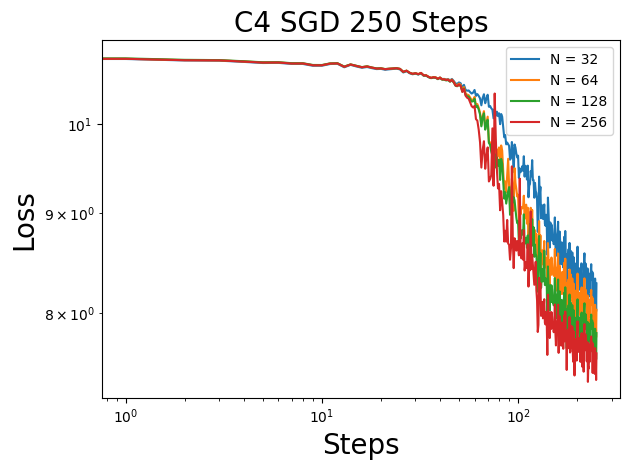

In [28]:
for i,loss in enumerate(all_losses):
    plt.loglog(loss, label = f'N = {dims[i]}')
plt.legend()
plt.xlabel('Steps', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.title(f'C4 SGD {T} Steps',fontsize = 20)
plt.tight_layout()
plt.show()

In [33]:
dim = 16
heads = 12
scale_exp = 1.0
adam = False
beta = 5.0

lr = 0.3
gamma = 0.25

depths = [16,32,64,128]
T = 250

all_losses = []

for i,depth in enumerate(depths):
    param_args = (dim, heads, depth, scale_exp,beta)
    opt_args = (lr, gamma, T)
    print(" ")
    print(f"L = {depth}")
    all_losses += [ train_model(param_args, opt_args, data = None, adam = adam) ]

 
L = 16
 loss = 8.249756813049316 
L = 32
 loss = 8.145248413085938 
L = 64
 loss = 8.065683364868164 
L = 128
 loss = 8.0115022659301765 
L = 256


2024-04-24 16:35:56.514983: W external/xla/xla/service/hlo_rematerialization.cc:2946] Can't reduce memory use below 55.81GiB (59931236054 bytes) by rematerialization; only reduced to 97.32GiB (104499868624 bytes), down from 149.35GiB (160364901680 bytes) originally
2024-04-24 16:36:07.044355: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit__lambda_] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-04-24 16:36:12.479113: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m5.434885035s

********************************
[Compiling module jit__lambda_] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-04-24 16:36:23.281978: W external/tsl/tsl/framework/bfc_allocator.cc:482] Allocator (GPU_0_b

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 108944729456 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  219.37MiB
              constant allocation:        12B
        maybe_live_out allocation:  363.89MiB
     preallocated temp allocation:  101.46GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:  102.03GiB
              total fragmentation:  213.90MiB (0.20%)
Peak buffers:
	Buffer 1:
		Size: 6.09GiB
		Operator: op_name="jit(<lambda>)/jit(main)/transpose(jvp(jit(<lambda>)))/mul" source_file="/tmp/ipykernel_3272866/3903931256.py" source_line=15
		XLA Label: fusion
		Shape: f32[256,127,50258]
		==========================

	Buffer 2:
		Size: 6.09GiB
		Operator: op_name="jit(<lambda>)/jit(main)/jvp(jit(<lambda>))/Transformer/Dense_0/dot_general[dimension_numbers=(((2,), (0,)), ((), ())) precision=None preferred_element_type=None]" source_file="/tmp/ipykernel_3272866/2746135811.py" source_line=80
		XLA Label: fusion
		Shape: f32[32512,50258]
		==========================

	Buffer 3:
		Size: 189.01MiB
		Operator: op_name="jit(<lambda>)/jit(main)/jvp(jit(<lambda>))/Transformer/Causal_Attention_14/div" source_file="/tmp/ipykernel_3272866/2746135811.py" source_line=28 deduplicated_name="loop_divide_fusion"
		XLA Label: fusion
		Shape: f32[256,12,127,127]
		==========================

	Buffer 4:
		Size: 189.01MiB
		Operator: op_name="jit(<lambda>)/jit(main)/jvp(jit(<lambda>))/Transformer/Causal_Attention_13/div" source_file="/tmp/ipykernel_3272866/2746135811.py" source_line=28 deduplicated_name="loop_divide_fusion"
		XLA Label: fusion
		Shape: f32[256,12,127,127]
		==========================

	Buffer 5:
		Size: 189.01MiB
		Operator: op_name="jit(<lambda>)/jit(main)/jvp(jit(<lambda>))/Transformer/Causal_Attention_12/div" source_file="/tmp/ipykernel_3272866/2746135811.py" source_line=28 deduplicated_name="loop_divide_fusion"
		XLA Label: fusion
		Shape: f32[256,12,127,127]
		==========================

	Buffer 6:
		Size: 189.01MiB
		Operator: op_name="jit(<lambda>)/jit(main)/jvp(jit(<lambda>))/Transformer/Causal_Attention_11/div" source_file="/tmp/ipykernel_3272866/2746135811.py" source_line=28 deduplicated_name="loop_divide_fusion"
		XLA Label: fusion
		Shape: f32[256,12,127,127]
		==========================

	Buffer 7:
		Size: 189.01MiB
		Operator: op_name="jit(<lambda>)/jit(main)/jvp(jit(<lambda>))/Transformer/Causal_Attention_10/div" source_file="/tmp/ipykernel_3272866/2746135811.py" source_line=28 deduplicated_name="loop_divide_fusion"
		XLA Label: fusion
		Shape: f32[256,12,127,127]
		==========================

	Buffer 8:
		Size: 189.01MiB
		Operator: op_name="jit(<lambda>)/jit(main)/jvp(jit(<lambda>))/Transformer/Causal_Attention_9/div" source_file="/tmp/ipykernel_3272866/2746135811.py" source_line=28 deduplicated_name="loop_divide_fusion"
		XLA Label: fusion
		Shape: f32[256,12,127,127]
		==========================

	Buffer 9:
		Size: 189.01MiB
		Operator: op_name="jit(<lambda>)/jit(main)/jvp(jit(<lambda>))/Transformer/Causal_Attention_8/div" source_file="/tmp/ipykernel_3272866/2746135811.py" source_line=28 deduplicated_name="loop_divide_fusion"
		XLA Label: fusion
		Shape: f32[256,12,127,127]
		==========================

	Buffer 10:
		Size: 189.01MiB
		Operator: op_name="jit(<lambda>)/jit(main)/jvp(jit(<lambda>))/Transformer/Causal_Attention_7/div" source_file="/tmp/ipykernel_3272866/2746135811.py" source_line=28 deduplicated_name="loop_divide_fusion"
		XLA Label: fusion
		Shape: f32[256,12,127,127]
		==========================

	Buffer 11:
		Size: 189.01MiB
		Operator: op_name="jit(<lambda>)/jit(main)/jvp(jit(<lambda>))/Transformer/Causal_Attention_6/div" source_file="/tmp/ipykernel_3272866/2746135811.py" source_line=28 deduplicated_name="loop_divide_fusion"
		XLA Label: fusion
		Shape: f32[256,12,127,127]
		==========================

	Buffer 12:
		Size: 189.01MiB
		Operator: op_name="jit(<lambda>)/jit(main)/jvp(jit(<lambda>))/Transformer/Causal_Attention_5/div" source_file="/tmp/ipykernel_3272866/2746135811.py" source_line=28 deduplicated_name="loop_divide_fusion"
		XLA Label: fusion
		Shape: f32[256,12,127,127]
		==========================

	Buffer 13:
		Size: 189.01MiB
		Operator: op_name="jit(<lambda>)/jit(main)/jvp(jit(<lambda>))/Transformer/Causal_Attention_4/div" source_file="/tmp/ipykernel_3272866/2746135811.py" source_line=28 deduplicated_name="loop_divide_fusion"
		XLA Label: fusion
		Shape: f32[256,12,127,127]
		==========================

	Buffer 14:
		Size: 189.01MiB
		Operator: op_name="jit(<lambda>)/jit(main)/jvp(jit(<lambda>))/Transformer/Causal_Attention_3/div" source_file="/tmp/ipykernel_3272866/2746135811.py" source_line=28 deduplicated_name="loop_divide_fusion"
		XLA Label: fusion
		Shape: f32[256,12,127,127]
		==========================

	Buffer 15:
		Size: 189.01MiB
		Operator: op_name="jit(<lambda>)/jit(main)/jvp(jit(<lambda>))/Transformer/Causal_Attention_2/div" source_file="/tmp/ipykernel_3272866/2746135811.py" source_line=28 deduplicated_name="loop_divide_fusion"
		XLA Label: fusion
		Shape: f32[256,12,127,127]
		==========================



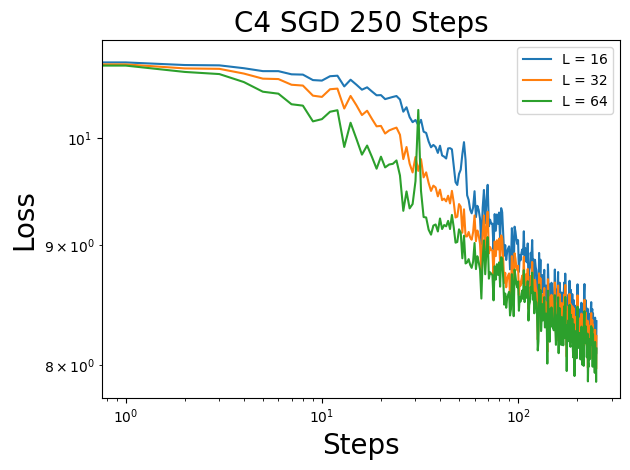

In [32]:
for i,loss in enumerate(all_losses):
    plt.loglog(loss, label = f'L = {depths[i]}')
plt.legend()
plt.xlabel('Steps', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.title(f'C4 SGD {T} Steps',fontsize = 20)
plt.tight_layout()
plt.show()

In [58]:
dim = 16
depth = 2
scale_exp = 1.0
adam = False
beta = 8.0

lr = 0.25
gamma = 0.5

head_vals = [16,32,64,128,256]
T = 250
all_losses = []

for i,heads in enumerate(head_vals):
    param_args = (dim, heads, depth, scale_exp,beta)
    opt_args = (lr, gamma, T)
    print(" ")
    print(f"G = {heads}")
    all_losses += [ train_model(param_args, opt_args, data = None, adam = adam) ]

 
G = 16
 loss = 7.813027858734131 
G = 32
 loss = 7.650411605834961 
G = 64
 loss = 7.453857421875 055
G = 128
 loss = 7.342370986938477 
G = 256
 loss = nan225301742553714

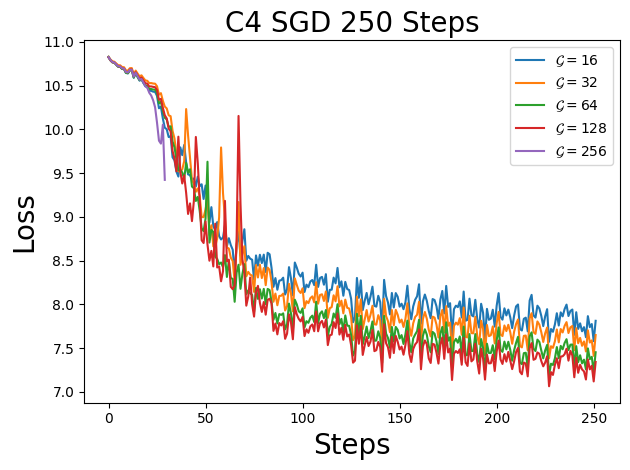

In [59]:
for i,loss in enumerate(all_losses):
    plt.plot(loss, label = r'$\mathcal{G} = %d$' % head_vals[i])
plt.legend()
plt.xlabel('Steps', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.title(f'C4 SGD {T} Steps',fontsize = 20)
plt.tight_layout()
plt.show()

## MAKE PLOTS 

In [1]:
import numpy as np
import argparse
import os
import matplotlib.pyplot as plt

def get_run_name(args):
    return "model_{}/dataset_{}/optimizer_{}/lr_{:.4f}/batch_size_{}/steps_{}/width_{}/heads_{}/depth_{}/scale_exp_{}/beta_{}/gamma_zero_{}".format(args.arch, args.dataset, args.optimizer, args.lr, args.batch_size, args.steps, args.width, args.heads, args.depth, args.scale_exp, args.beta, args.gamma_zero)

In [7]:

class Args(argparse.Namespace):
    lr = 0.05
    epochs = 100
    arch = 'LLM'
    dataset = 'C4'
    optimizer = 'adam'
    seed = 1111
    batch_size = 256
    steps = 50000
    width = 32
    depth = 4
    scale_exp = 1.0
    gamma_zero = 0.25
    beta = 4.0
    heads = 10

args = Args()

run_name = get_run_name(args)
save_dir = '/n/holyscratch01/pehlevan_lab/Users/bbordelon/bbordelon/Learn_gates/C4_LLM'


save_path = os.path.join(save_dir, run_name.replace("/", "-")) + '.npy'


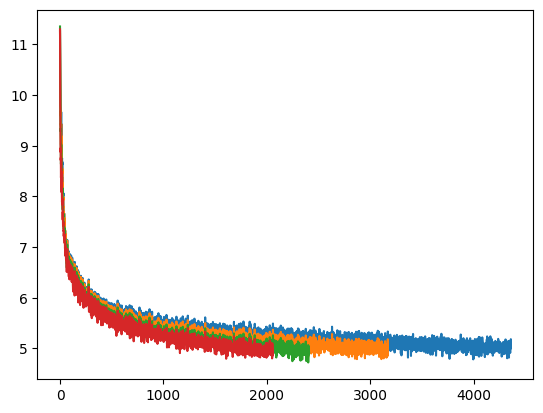

In [12]:

widths = [16,32,64,128]

all_losses = []

for i, width in enumerate(widths):
    args.width = width
    
    run_name = get_run_name(args)
    save_path = os.path.join(save_dir, run_name.replace("/", "-")) + '.npy'
    all_losses += [np.load(save_path)]


In [24]:
for losses in all_losses:
    print(len(losses))
    print(losses[-1])
    print(losses[5000])
    print(np.amin(losses[np.isnan(losses)==0]))
plt.show()

50002
nan
nan
4.7853107
50002
nan
nan
4.790579
50002
nan
nan
4.7242503
50002
nan
nan
4.7977424


In [14]:
!nvidia-smi

Mon Apr 22 09:35:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA H100 80GB HBM3          On  | 00000000:06:00.0 Off |                    0 |
| N/A   24C    P0              66W / 700W |      4MiB / 81559MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--